# Intro to LangChain

In [1]:
from IPython.display import clear_output

In [2]:
%pip install langchain
%pip install -qU huggingface_hub
clear_output()

## 0. Initial setup

In [3]:
import os
import yaml
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
hf_key = data_loaded['HF_API_KEY']

In [6]:
os.environ['HUGGINGFACEHUB_API_TOKEN'] = hf_key

## 1. First steps

Objective: Chain together different components in order to enhance the use-cases around LLMs.
The chains include components from modules scuh as:
* **Prompt templates**: templates for prompting
* **LLMs**: The basic component, the LLMs used
* **Agents**: They use the LLMs to decide what actions should be taken
* **Memory**:
  * Short-term: Current context; in-context learning.
  * Long-term: past interactions; usually using a vector DB.
* **Tools**: Additional tools such as Wikipedia Search API, Code Interpreter or Math Engine.

LLM Agent Framework [2]
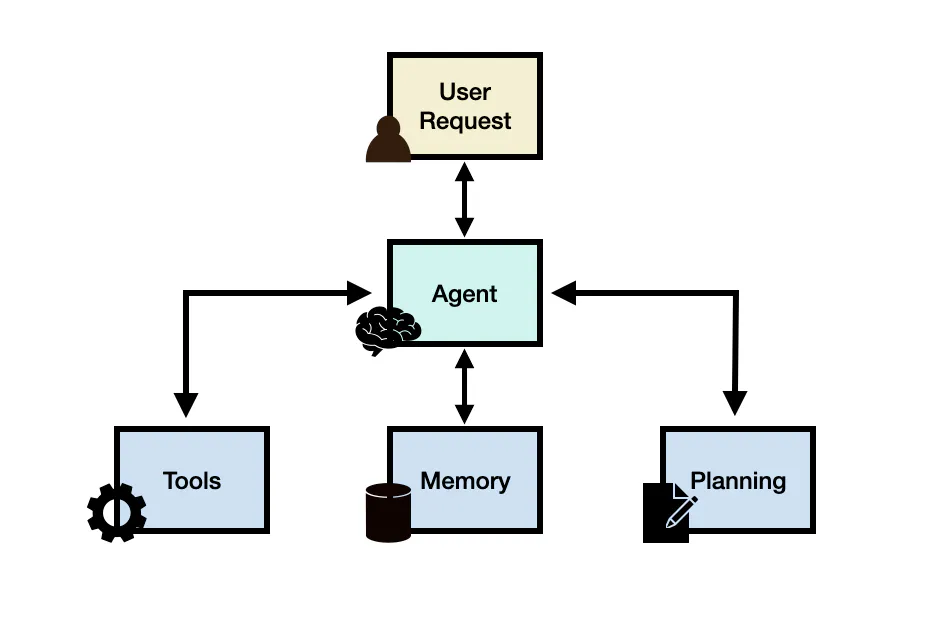

References:
* Tutorial based on [1], [3]

* [1]: https://www.pinecone.io/learn/series/langchain/langchain-intro/
* [2]: https://www.promptingguide.ai/research/llm-agents
* [3]: https://python.langchain.com/docs/integrations/llms/huggingface_endpoint/

In [7]:
import langchain
from langchain import PromptTemplate, LLMChain
from langchain_community.llms import (
    HuggingFaceEndpoint,
    HuggingFaceTextGenInference,
    HuggingFaceHub
)

In [8]:
langchain.debug = False

In [9]:
# Initialize HF LLM
repo_id = "mistralai/Mistral-7B-Instruct-v0.2"
#repo_id = "HuggingFaceH4/zephyr-7b-beta"
#repo_id = "google/gemma-7b"
#repo_id = "google/flan-ul2"

task = 'text-generation'
dct_llm_params = {
    "max_new_tokens": 128,
    #"top_k": 5,
    "temperature": 0.5,
    #"repetition_penalty": 1.03,
}

'''
dct_input_params = dct_llm_params.copy()
dct_input_params['repo_id'] = repo_id
dct_input_params['task'] = task
llm = HuggingFaceEndpoint(**dct_input_params)
'''

llm = HuggingFaceHub(
    repo_id=repo_id,
    task=task,
    model_kwargs=dct_llm_params,
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.huggingface_hub.HuggingFaceHub` was deprecated in langchain-community 0.0.21 and will be removed in 0.2.0. Use HuggingFaceEndpoint instead.
  warn_deprecated(


In [10]:
# Build prompt template for simple question-answering
template = """Question: {question}

Answer: Let's think step by step."""
print(template)
prompt = PromptTemplate(template=template, input_variables=["question"])

Question: {question}

Answer: Let's think step by step.


In [11]:
# Execute LLM
llm_chain = LLMChain(
    prompt=prompt,
    llm=llm
)
question = "Who won the FIFA World Cup in the year 1994? "
print(llm_chain.run(question))

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Question: Who won the FIFA World Cup in the year 1994? 

Answer: Let's think step by step. The FIFA World Cup is an international football tournament that takes place every four years. The 1994 FIFA World Cup was held in the United States from June 17 to July 17, 1994. The final match was played on July 17, 1994, between Brazil and Italy. Brazil won the match with a score of 0-0 (3-2) in a penalty shootout after the game ended 0-0 after extra time. Therefore, Brazil won the 1994 FIFA World Cup.


In [12]:
# Chain multiple questions
qs = [
    {'question': "Who won the FIFA World Cup in the year 1994?"},
    {'question': "If I am 6 ft 4 inches, how tall am I in centimeters?"},
    {'question': "Who was the 12th person on the moon?"},
    {'question': "How many eyes does a blade of grass have?"}
]
res = llm_chain.generate(qs)
res

LLMResult(generations=[[Generation(text="Question: Who won the FIFA World Cup in the year 1994?\n\nAnswer: Let's think step by step. The FIFA World Cup is an international soccer competition. In 1994, the World Cup was hosted by the United States. The winning team was Brazil. Brazil won the tournament by defeating Italy in the final match. So, the answer is Brazil won the FIFA World Cup in the year 1994.")], [Generation(text="Question: If I am 6 ft 4 inches, how tall am I in centimeters?\n\nAnswer: Let's think step by step. We know that:\n1 inch = 2.54 centimeters\n\nSo to find the height in centimeters, we need to multiply the number of inches by the conversion factor:\n\nHeight in centimeters = Height in inches * Conversion factor\n                                   = 6 ft 4 inches * 2.54 cm/inch\n\nFirst, we need to convert feet to inches:\n1 ft = 12 inches\nSo, 6 ft = 6 * 12 = 72 inches\n\nNow, we have the height in inches, which")], [Generation(text="Question: Who was the 12th per

In [13]:
# All questions within the same prompt
multi_template = """Answer the following questions one at a time.

Questions:
{questions}

Answers:
"""
long_prompt = PromptTemplate(
    template=multi_template,
    input_variables=["questions"]
)

llm_chain = LLMChain(
    prompt=long_prompt,
    llm=llm
)

qs_str = (
    "Who won the FIFA World Cup in the year 1994?\n" +
    "If I am 6 ft 4 inches, how tall am I in centimeters?\n" +
    "Who was the 12th person on the moon?" +
    "How many eyes does a blade of grass have?"
)

print(llm_chain.run(qs_str))

Answer the following questions one at a time.

Questions:
Who won the FIFA World Cup in the year 1994?
If I am 6 ft 4 inches, how tall am I in centimeters?
Who was the 12th person on the moon?How many eyes does a blade of grass have?

Answers:
1. The FIFA World Cup in the year 1994 was won by Brazil.
2. To convert height from feet and inches to centimeters, you can use the following formula: cm = (feet × 12) + inches × 2.54
So, if you are 6 ft 4 inches tall, your height in centimeters would be: (6 × 12) + (4 × 2.54) = 213.36 cm
3. The 12th person to walk on the moon was Harrison Schmitt, an


## 2. Prompt templates

Structure of a prompt [1]:
* **Instructions**: for telling the model what to do (what task to perform, how it should use inputs and/or external infromation...)
* **External information or context**: Additional information included within the prompt (e.g., long-term memory via vector databases, data obtained theough APIs, manual info added to the prompt...)
* **User input or query**: Query directly given by the user to the system
* **Output indicator**: Beginning of the generated text (e.g., "import" when the text generated is a Python code)


Example. In this prompt we have Instructions, Context, Question (user input) and Output indicator ("Answer:")


>  """Answer the question based on the context below. If the
question cannot be answered using the information provided answer
with "I don't know".
>
>Context: Large Language Models (LLMs) are the latest models used in NLP.
>
>Their superior performance over smaller models has made them incredibly
useful for developers building NLP enabled applications. These models
can be accessed via Hugging Face's `transformers` library, via OpenAI
using the `openai` library, and via Cohere using the `cohere` library.
>
>Question: Which libraries and model providers offer LLMs?
>
>Answer: """

References:
* [1]: https://github.com/pinecone-io/examples/blob/master/learn/generation/langchain/handbook/01-langchain-prompt-templates.ipynb
* [2]: https://python.langchain.com/docs/modules/model_io/prompts/few_shot_examples/

In [14]:
import langchain
from langchain import PromptTemplate, LLMChain
from langchain_community.llms import (
    HuggingFaceEndpoint,
    HuggingFaceTextGenInference,
    HuggingFaceHub
)

In [15]:
template = """Answer the question based on the context below. If the
question cannot be answered using the information provided answer
with "I don't know".

Context: Large Language Models (LLMs) are the latest models used in NLP.
Their superior performance over smaller models has made them incredibly
useful for developers building NLP enabled applications. These models
can be accessed via Hugging Face's `transformers` library, via OpenAI
using the `openai` library, and via Cohere using the `cohere` library.

Question: {query}

Answer: """

prompt_template = PromptTemplate(
    input_variables=["query"],
    template=template
)

In [16]:
print(
    prompt_template.format(
        query="Which libraries and model providers offer LLMs?"
    )
)

Answer the question based on the context below. If the
question cannot be answered using the information provided answer
with "I don't know".

Context: Large Language Models (LLMs) are the latest models used in NLP.
Their superior performance over smaller models has made them incredibly
useful for developers building NLP enabled applications. These models
can be accessed via Hugging Face's `transformers` library, via OpenAI
using the `openai` library, and via Cohere using the `cohere` library.

Question: Which libraries and model providers offer LLMs?

Answer: 


In [17]:
# Initialize HF LLM
repo_id = "mistralai/Mistral-7B-Instruct-v0.2"
#repo_id = "HuggingFaceH4/zephyr-7b-beta"
#repo_id = "google/gemma-7b"
#repo_id = "google/flan-ul2"

task = 'text-generation'
dct_llm_params = {
    "max_new_tokens": 128,
    #"top_k": 5,
    "temperature": 0.5,
    #"repetition_penalty": 1.03,
}

llm = HuggingFaceHub(
    repo_id=repo_id,
    task=task,
    model_kwargs=dct_llm_params,
)

In [18]:
# Execute LLM
llm_chain = LLMChain(
    prompt=prompt_template,
    llm=llm
)
query = "Which libraries and model providers offer LLMs?"
print(llm_chain.run(query))

Answer the question based on the context below. If the
question cannot be answered using the information provided answer
with "I don't know".

Context: Large Language Models (LLMs) are the latest models used in NLP.
Their superior performance over smaller models has made them incredibly
useful for developers building NLP enabled applications. These models
can be accessed via Hugging Face's `transformers` library, via OpenAI
using the `openai` library, and via Cohere using the `cohere` library.

Question: Which libraries and model providers offer LLMs?

Answer:  Hugging Face's `transformers` library, OpenAI using the `openai` library, and Cohere using the `cohere` library all offer Large Language Models (LLMs).


### 2.1. Few Shot Templates
Learning on a LLM:
  * **Parametric Knowledge**: Knowledge learned within the LLM training, stored in the models' weights.
  * **Source Knowledge**: Knowledge provided to the LLM at inference time (e.g., within the prompt).

With *FewShotPromptTemplate*, the aim is to provide few-shot training as *source knowledge*.

In [25]:
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain_community.llms import HuggingFaceHub

In [49]:
# Initialize HF LLM
repo_id = "mistralai/Mistral-7B-Instruct-v0.2"
#repo_id = "HuggingFaceH4/zephyr-7b-beta"
#repo_id = "google/gemma-7b"
#repo_id = "google/flan-ul2"

task = 'text-generation'
dct_llm_params = {
    "max_new_tokens": 128,
    #"top_k": 5,
    "temperature": 0.3,
    #"repetition_penalty": 1.03,
}

llm = HuggingFaceHub(
    repo_id=repo_id,
    task=task,
    model_kwargs=dct_llm_params,
)

In [50]:
# First, we create a set of Question-Answers examples
examples = [
    {
        "question": "Who lived longer, Muhammad Ali or Alan Turing?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali
""",
    },
    {
        "question": "When was the founder of craigslist born?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952
""",
    },
    {
        "question": "Who was the maternal grandfather of George Washington?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball
""",
    },
    {
        "question": "Are both the directors of Jaws and Casino Royale from the same country?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate Answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate Answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate Answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate Answer: New Zealand.
So the final answer is: No
""",
    },
]

In [51]:
# Formater for the few-shot examples
example_prompt = PromptTemplate(
    input_variables=["question", "answer"], template="Question: {question}\n{answer}"
)
print(example_prompt.format(**examples[0]))

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali



In [52]:
# Feed examples and formatter to FewShotPromptTemplate
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="Answer as if you are an expert in history.",
    suffix="Question: {input}",
    input_variables=["input"],
    example_separator="\n"
)
#print(prompt.format(input="Who was the father of Mary Ball Washington?"))

In [53]:
# Execute LLM
llm_chain = LLMChain(
    prompt=prompt,
    llm=llm
)
query = "Who lived longer, St. John Paul II or St. Giuseppe Moscati?"
print(llm_chain.run(query))

Answer as if you are an expert in history.
Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali

Question: When was the founder of craigslist born?

Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952

Question: Who was the maternal grandfather of George Washington?

Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Fol